# In this Notebook we are attempting to predict if a person will win their next fight depending on how they performed on their last 5 fights

## Library Imports

In [2]:
import sys
sys.path.insert(1, '../helpers')

import pandas as pd
import numpy as np
import talos as ta

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support

from talos.model.normalizers import lr_normalizer
from talos.model.hidden_layers import hidden_layers

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D, LSTM
from keras.optimizers import Adam, Nadam, RMSprop
from keras.losses import logcosh, binary_crossentropy
from keras.activations import relu, elu, sigmoid

import matplotlib.pyplot as plt
%matplotlib inline

from make_career import make_career

## Loading the dataset

In [3]:
features, labels = make_career(N_FIGHT_CAREER=5)
labels = labels.reshape(-1,)
score_cols = ['precision', 'recall', 'fbeta_score', 'support']

Creating careers using 5 fight intervals and predicting 1 future fights
Original fight data shape: (5062, 153)
Fights 2x shape: (10124, 95)
Fights after pre-processing: (10124, 100)

Features shape: (3220, 5)
Labels shape: (3220, 1)

Features is a 2D matrix with 3220 rows
Each row contains has 5 fights, and each fight has 100 columns

Labels is a 2D matrix with 3220 rows
Each row contains the the prediction for the next 1 fight(s)


In [4]:
print('Features {}'.format(features.shape))
print('Labels {}'.format(labels.shape))

Features (3220, 5)
Labels (3220,)


## Preprocess Features

## Generates np.array of shape (3220, 5 * features)

In [5]:
def collapse_n_fights():
    num_cols, cat_cols = get_column_types()
    
    # Collect only the features we want
    new_features = []
    for window in features:
        window_arr = list(window.reshape(1,-1))[0]
        fight_window = np.array([])
        for fight in window_arr:
            fight_arr = np.array([fight[i] for i in num_cols])
            np.nan_to_num(fight_arr, copy=False)
            fight_window = np.append(fight_window, fight_arr)
        new_features.append(fight_window)
    
    new_features, new_labels = shuffle(np.array(new_features), labels)
    X_train, X_test, y_train, y_test = train_test_split(new_features, new_labels, random_state=0, train_size=0.90)
    
    # Scale the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

def plot_training_results(history_obj):
    acc = history_obj.history['accuracy']
    val_acc = history_obj.history['val_accuracy']
    loss = history_obj.history['loss']
    val_loss = history_obj.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    fig, (accuracy_axis, loss_axis) = plt.subplots(1, 2, figsize=(20, 5))

    accuracy_axis.plot(epochs, acc, 'bo', label='Training acc')
    accuracy_axis.plot(epochs, val_acc, 'b', label='Validation acc')
    accuracy_axis.set_title('Training and validation accuracy')
    accuracy_axis.set_ylabel('Accuracy')
    accuracy_axis.set_xlabel('Epoch')
    accuracy_axis.legend()

    loss_axis.plot(epochs, loss, 'bo', label='Training loss')
    loss_axis.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_axis.set_title('Training and validation loss')
    loss_axis.set_ylim(0, 3)
    loss_axis.set_ylabel('Loss')
    loss_axis.set_xlabel('Epoch')
    loss_axis.legend()
    fig.show()

## Model Parameters and Definitions

In [6]:
# Define hyperparameters to use in Grid Search for DNN
dnn_params = {
     'lr': [0.01, 0.1, 1],
     'first_neuron': [128],
     'hidden_layers': [1],
     'batch_size': [64],
     'epochs': [10],
     'dropout': [0.01],
     'optimizer': [Adam],
     'shapes':['funnel'],
     'losses': [binary_crossentropy],
     'activation': [relu],
     'last_activation': [sigmoid],
}

# dnn_params = {
#     'lr': [0.01, 0.1, 1],
#     'first_neuron': [128],
#     'hidden_layers': [1],
#     'batch_size': [64, 128, 256],
#     'epochs': [10, 25],
#     'dropout': [0.01, 0.1],
#     'optimizer': [Adam],
#     'shapes':['funnel'],
#     'losses': [binary_crossentropy],
#     'activation': [relu],
#     'last_activation': [sigmoid],
# }

# Define hyperparameters to use in Grid Search for CNN
# cnn_params = {
#     'lr': [0.01],
#     'num_filters': [64],
#     'kernel_size': [2],
#     'batch_size': [64],
#     'epochs': [5],
#     'dropout': [0.01],
#     'flatten_layer': [100], 
#     'optimizer': [Adam],
#     'losses': [binary_crossentropy],
#     'activation': [relu],
#     'last_activation': [sigmoid],
# }

# Longer Run
cnn_params = {
    'lr': [0.01, 0.1, 1],
    'num_filters': [64, 128],
    'kernel_size': [2],
    'batch_size': [64],
    'epochs': [5, 15],
    'dropout': [0.01],
    'flatten_layer': [100], 
    'optimizer': [Adam],
    'losses': [binary_crossentropy],
    'activation': [relu],
    'last_activation': [sigmoid],
}

In [7]:
# Get the first fight window and the first fight in that window
def get_column_types():
    num_cols = []
    cat_cols = []
    for fight in features[0][0]:
        feature_type = type(features[1][1][fight])
        if feature_type is not float and feature_type is not int:
            cat_cols.append(fight)
        else:
            num_cols.append(fight)
            
    return num_cols, cat_cols

In [8]:
dnn_scores = []
def get_dnn(x_train, y_train, x_val, y_val, params, test_model=False):
    
    model = Sequential()
    # Input Layer
    model.add(Dense(params["first_neuron"], 
                    activation=params['activation'], 
                    input_dim=X_train.shape[1]))
    
    model.add(Dropout(params['dropout']))
    
    # Hidden Layers
    hidden_layers(model, params, 1)
    
    # Output Layers
    model.add(Dense(1, activation=params['last_activation']))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])), 
                  metrics=['accuracy'])
                  
    history = model.fit(x_train, y_train,
                       validation_data=[x_val, y_val],
                       batch_size=params['batch_size'],
                       epochs=params['epochs'],
                       verbose=0)
    
    score = precision_recall_fscore_support(y_val, model.predict_classes(x_val), average='binary')
    dnn_scores.append(score)
    
    if test_model:
        model.summary()
        plot_training_results(history)
        

    return history, model


cnn_scores = []
def get_cnn(x_train, y_train, x_val, y_val, params, test_model=False):
    model = Sequential()
    
    # Convolutional Layers
    model.add(Conv1D(filters=params["num_filters"], kernel_size=params["kernel_size"], activation='relu', input_shape=(5, 97)))
    model.add(Conv1D(filters=params["num_filters"], kernel_size=params["kernel_size"], activation='relu'))
    model.add(Dropout(params['dropout']))
    
    # Flatten Layers
    model.add(Flatten())
    model.add(Dense(params["flatten_layer"], activation='relu'))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])), 
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                       validation_data=[x_val, y_val],
                       batch_size=params['batch_size'],
                       epochs=params['epochs'],
                       verbose=0)
    
    score = precision_recall_fscore_support(y_val, model.predict_classes(x_val), average='binary')
    cnn_scores.append(score)
    
    if test_model:
        plot_training_results(history)
        model.summary()

    return history, model


lstm_scores = []
def get_lstm(x_train, y_train, x_val, y_val, test_model=False):
    model = Sequential()
    
    model.add(LSTM(50, 
                   input_shape=(5, 97),
                   recurrent_dropout=0.2)) #, return_sequences=True
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", 
                  optimizer=Adam(learning_rate=0.01), 
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                       validation_data=[x_val, y_val],
                       batch_size=64,
                       epochs=30,
                       verbose=1)
    
    score = precision_recall_fscore_support(y_val, model.predict_classes(x_val), average='binary')
    lstm_scores.append(score)
    
    if test_model:
        plot_training_results(history)
        model.summary()

    return history, model

## Building a DNN to predict the winner using last n fights

In [9]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()

# Create the Neural Network
dnn_model = ta.Scan(
    x=X_train,
    y=y_train,
    model=get_dnn,
    params=dnn_params,
    experiment_name='LAST_5_DNN',
)

100%|██████████| 3/3 [00:17<00:00,  5.76s/it]


In [10]:
results_df = dnn_model.data
dnn_cols = list(results_df.columns)

new_df_data = []
for index, row_data in results_df.iterrows():
    new_row = dict()
    
    for col in dnn_cols:
        new_row[col] = row_data[col]
    
    for score_index, col in enumerate(score_cols):
        new_row[col] = dnn_scores[index][score_index]
        
    new_df_data.append(new_row)

dnn_df = pd.DataFrame(new_df_data)
dnn_df.drop(columns=['round_epochs', 'batch_size', 'epochs', 'support', 'precision', 'recall', 'shapes', 'first_neuron'], inplace=True)
top_5_val_dnn = dnn_df.sort_values(by=['val_accuracy'], ascending=False).head(5)
top_5_val_dnn

,val_loss,val_accuracy,loss,accuracy,activation,dropout,hidden_layers,last_activation,losses,lr,optimizer,fbeta_score
1,0.692538,0.564368,0.674842,0.612919,<function relu at 0x7ff577071620>,0.01,1,<function sigmoid at 0x7ff577071730>,<function binary_crossentropy at 0x7ff57709f0d0>,0.10,<class 'keras.optimizers.Adam'>,0.698488
2,0.804012,0.533333,0.485496,0.764300,<function relu at 0x7ff577071620>,0.01,1,<function sigmoid at 0x7ff577071730>,<function binary_crossentropy at 0x7ff57709f0d0>,1.00,<class 'keras.optimizers.Adam'>,0.597222
0,0.705219,0.526437,0.705026,0.553254,<function relu at 0x7ff577071620>,0.01,1,<function sigmoid at 0x7ff577071730>,<function binary_crossentropy at 0x7ff57709f0d0>,0.01,<class 'keras.optimizers.Adam'>,0.634752


## Building a CNN to predict the winner using last n fights

In [11]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()
X_train = X_train.reshape(X_train.shape[0], 5, 97)
X_test = X_test.reshape(X_test.shape[0], 5, 97)

# Create the Neural Network
cnn_model = ta.Scan(
    x=X_train,
    y=y_train,
    model=get_cnn,
    params=cnn_params,
    experiment_name='LAST_5_CNN',
)

100%|██████████| 12/12 [01:48<00:00,  9.06s/it]


In [12]:
results_df = cnn_model.data
cnn_cols = list(results_df.columns)

new_df_data = []
for index, row_data in results_df.iterrows():
    new_row = dict()
    
    for col in cnn_cols:
        new_row[col] = row_data[col]
    
    for score_index, col in enumerate(score_cols):
        new_row[col] = cnn_scores[index][score_index]
        
    new_df_data.append(new_row)

cnn_df = pd.DataFrame(new_df_data)
cnn_df.drop(columns=['round_epochs', 'batch_size', 'epochs', 'support', 'precision', 'recall', 'flatten_layer', 'kernel_size'], inplace=True)
top_5_val_cnn = cnn_df.sort_values(by=['val_accuracy'], ascending=False).head(5)
top_5_val_cnn

,val_loss,val_accuracy,loss,accuracy,activation,dropout,last_activation,losses,lr,num_filters,optimizer,fbeta_score
3,0.685238,0.590805,0.631475,0.666667,<function relu at 0x7ff577071620>,0.01,<function sigmoid at 0x7ff577071730>,<function binary_crossentropy at 0x7ff57709f0d0>,0.10,128,<class 'keras.optimizers.Adam'>,0.711974
7,0.682192,0.579310,0.663164,0.597633,<function relu at 0x7ff577071620>,0.01,<function sigmoid at 0x7ff577071730>,<function binary_crossentropy at 0x7ff57709f0d0>,0.01,128,<class 'keras.optimizers.Adam'>,0.701468
2,0.689408,0.572414,0.660293,0.609467,<function relu at 0x7ff577071620>,0.01,<function sigmoid at 0x7ff577071730>,<function binary_crossentropy at 0x7ff57709f0d0>,0.10,64,<class 'keras.optimizers.Adam'>,0.698052
5,0.775833,0.570115,0.435250,0.821006,<function relu at 0x7ff577071620>,0.01,<function sigmoid at 0x7ff577071730>,<function binary_crossentropy at 0x7ff57709f0d0>,1.00,128,<class 'keras.optimizers.Adam'>,0.656881
9,0.712691,0.558621,0.511955,0.796844,<function relu at 0x7ff577071620>,0.01,<function sigmoid at 0x7ff577071730>,<function binary_crossentropy at 0x7ff57709f0d0>,0.10,128,<class 'keras.optimizers.Adam'>,0.647706


## Building an LSTM to predict the winner using last n fights

Train on 2898 samples, validate on 322 samples
Epoch 1/30
2898/2898 [==============================] - 3s 903us/step - loss: 0.6955 - accuracy: 0.5480 - val_loss: 0.6727 - val_accuracy: 0.6025
Epoch 2/30
2898/2898 [==============================] - 1s 237us/step - loss: 0.6489 - accuracy: 0.6177 - val_loss: 0.6975 - val_accuracy: 0.5776
Epoch 3/30
2898/2898 [==============================] - 1s 236us/step - loss: 0.6230 - accuracy: 0.6453 - val_loss: 0.7010 - val_accuracy: 0.5683
Epoch 4/30
2898/2898 [==============================] - 1s 278us/step - loss: 0.5899 - accuracy: 0.6846 - val_loss: 0.7144 - val_accuracy: 0.5404
Epoch 5/30
2898/2898 [==============================] - 1s 212us/step - loss: 0.5393 - accuracy: 0.7398 - val_loss: 0.7186 - val_accuracy: 0.5621
Epoch 6/30
2898/2898 [==============================] - 1s 297us/step - loss: 0.4774 - accuracy: 0.7802 - val_loss: 0.8171 - val_accuracy: 0.5186
Epoch 7/30
2898/2898 [==============================] - 1s 260us/step - loss:

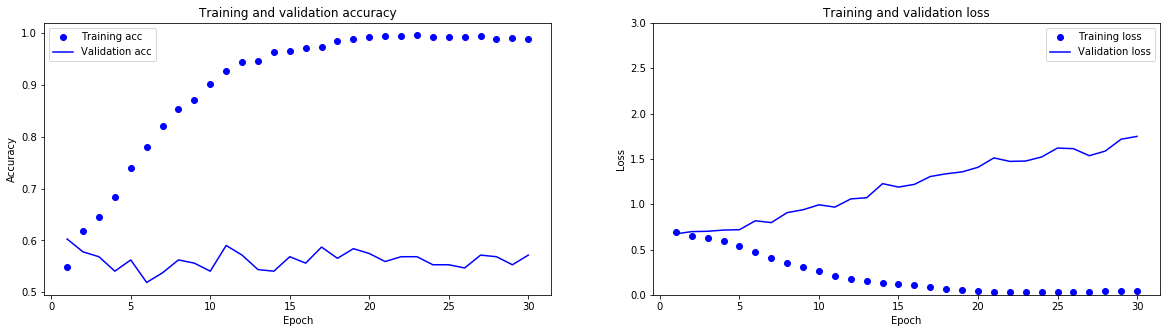

In [13]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()
X_train = X_train.reshape(X_train.shape[0], 5, 97)
X_test = X_test.reshape(X_test.shape[0], 5, 97)

history, model = get_lstm(X_train, y_train, X_test, y_test, test_model=True)

In [14]:
hist = history.history
lstm_data = [hist['accuracy'][-1], hist['val_accuracy'][-1], hist['loss'][-1], hist['val_loss'][-1]]
lstm_data = lstm_data + [lstm_scores[0][0], lstm_scores[0][1], lstm_scores[0][2], lstm_scores[0][3]]
lstm_cols = ['accuracy', 'val_accuracy', 'loss', 'val_loss'] + score_cols


lstm_df = pd.DataFrame(data=[lstm_data], columns=lstm_cols)
lstm_df.sort_values(by=['val_accuracy'], ascending=False, inplace=True)
lstm_df

,accuracy,val_accuracy,loss,val_loss,precision,recall,fbeta_score,support
0,0.988958,0.571429,0.046615,1.748532,0.61809,0.664865,0.640625,None
